# Predicting Web Traffic for Wikipedia Articles

In this notebook, we will explore the problem of forecasting future values of multiple time series using the data from the Kaggle competition [Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting). The goal of this competition is to test state-of-the-art methods on the problem of predicting future web traffic for approximately 145,000 Wikipedia articles.

The data consists of daily page views for each article from July 1st, 2015 to December 31st, 2016. The page views are split into desktop and mobile traffic. The articles are also grouped by language and project (e.g. en.wikipedia.org).

We will use various methods to analyze and visualize the data, such as univariate and multivariate models, hierarchical time series modeling, data augmentation, anomaly and outlier detection and cleaning, missing value imputation, etc. We will also evaluate our models using appropriate metrics and compare them with the baseline methods provided by the competition organizers.

In this notebook we will:

- Load and explore the data
- Perform some feature engineering
- Build some baseline models using traditional forecasting methods
- Evaluate our models using different metrics
- Submit our predictions to Kaggle

## Load Packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pathlib
import janitor
import janitor.timeseries

## Load Data

The data is provided in two files: `train_1.csv` and `key_1.csv`. The `train_1.csv` file contains the page views for each article and the `key_1.csv` file contains the page names and the dates for which we need to make predictions.

The `train_1.csv` file contains 145,063 rows and 551 columns. The first column contains the page names and the remaining 550 columns contain the page views for each day. The `key_1.csv` file contains 39,546 rows and 2 columns. The first column contains the page names and the second column contains the dates for which we need to make predictions.

In [26]:
root = pathlib.Path('~/datasets/web-traffic-time-series-forecasting').expanduser()

In [27]:
train = pd.read_csv(str(root / 'train_1.csv')).sample(frac=0.01 / 2)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
48792,Charles_Brauer_de.wikipedia.org_all-access_spider,3.0,2.0,2.0,10.0,1.0,5.0,1.0,3.0,9.0,...,8.0,3.0,5.0,2.0,5.0,9.0,2.0,8.0,4.0,5.0
68316,Borussia_Dortmund_de.wikipedia.org_desktop_all...,969.0,857.0,946.0,771.0,630.0,911.0,1330.0,918.0,993.0,...,851.0,701.0,425.0,389.0,342.0,520.0,512.0,477.0,398.0,253.0
117865,Jürgen_Domian_de.wikipedia.org_mobile-web_all-...,38.0,45.0,54.0,54.0,39.0,42.0,59.0,45.0,47.0,...,310.0,212.0,265.0,262.0,206.0,190.0,151.0,182.0,155.0,143.0
26929,Philippe_Pétain_fr.wikipedia.org_all-access_al...,495.0,567.0,475.0,476.0,473.0,498.0,571.0,570.0,573.0,...,753.0,1048.0,1056.0,787.0,873.0,881.0,1316.0,1421.0,897.0,860.0
96761,Sombras_tenebrosas_(película_de_2012)_es.wikip...,132.0,126.0,120.0,141.0,170.0,155.0,142.0,98.0,171.0,...,226.0,171.0,2183.0,552.0,267.0,203.0,192.0,197.0,188.0,397.0


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 48792 to 12023
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 3.1+ MB


As we can see, the data is not in a tidy format. We need to reshape it to a tidy format. We will use the melt function from pandas to do this. We will also use the regex to extract the date from the column name. We will also use the to_datetime function to convert the date column to a datetime object.

In [29]:
# tidy up the data

df = train.set_index('Page').stack().reset_index()
df.columns = ['Page', 'Date', 'Visits']
df['Date'] = pd.to_datetime(df['Date'])
df = df.clean_names().sort_timestamps_monotonically(direction="increasing")

# combine page and date columns and get id for each unique combination from the key dataframe
# create a new column for id

df['id'] = df['page'] + '_' + df['date'].astype(str)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370692 entries, 0 to 370691
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   page    370692 non-null  object        
 1   date    370692 non-null  datetime64[ns]
 2   visits  370692 non-null  float64       
 3   id      370692 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 11.3+ MB


## Explore Data

In the following sections, we will explore the data and try to understand the patterns in the data.

### How Page Language Affects Traffic

I want to explore how the languages used in Wikipedia pages might influence the traffic data. I'll use a simple regex to find the language code in the URL. Some URLs are not from Wikipedia but from Wikimedia. They don't have a language code, so I'll label them as `missing`. These are mostly images or other media that don't have a specific language.

The Page column contains pages in different languages. We will extract the language from the page name and create a new column called Language. We will also create an access column that contains the access type (mobile or desktop) and agent column that contains the type of user agent (spider, crawler, robot, etc.). In addition, we will create an article column that contains the name of the article.

In [31]:
pattern = r'\w\w(?=\.wikipedia)'

# extract language/locale from 'page' column using regex pattern
df['language'] = df['page'].apply(
    lambda x: re.search(pattern, x).group(0) if re.search(pattern, x) else 'missing'
)


# define regex patterns
access_pattern = r'(?<=\.org_)(\w+-?\w+)(?=_)'
agent_pattern = r'(?<=_)[a-zA-Z]+(-[a-zA-Z]+)*$'
article_pattern = r'(?<=\d_\w\w\.)(.*)'

# extract access type from 'page' column using regex pattern
df['access'] = df['page'].apply(
    lambda x: re.search(access_pattern, x).group(1) if re.search(access_pattern, x) else None
)

# extract user agent from 'page' column using regex pattern
df['agent'] = df['page'].apply(
    lambda x: re.search(agent_pattern, x).group(0) if re.search(agent_pattern, x) else None
)

# # # extract article name from 'page' column using regex pattern
df['article'] = (
    df['page']
    .str.extract(r'(.+?)\.', expand=False)
    .apply(lambda x: x.rsplit('_', 1)[0] if '_' in x else None)
)

df['rolling_mean_visits'] = df.groupby('page')['visits'].transform(lambda x: x.rolling(7, 1).mean())

df.head()

,page,date,visits,id,language,access,agent,article,rolling_mean_visits
0,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-01,3.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,3.000000
1,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-02,2.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,2.500000
2,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-03,2.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,2.333333
3,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-04,10.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,4.250000
4,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-05,1.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,3.600000


In [32]:
df.language.value_counts()

en         56174
de         54767
fr         53781
ja         52340
missing    45675
ru         37495
zh         36681
es         33779
Name: language, dtype: int64

As we can see, there are 7 different languages in the dataset. 

- English (en)
- Japanese (ja)
- Deutsch (de)
- French (fr)
- Chinese (zh)
- Spanish (es)
- Russian (ru)

We can also see that there are some missing values in the language column. We will deal with these missing values later.

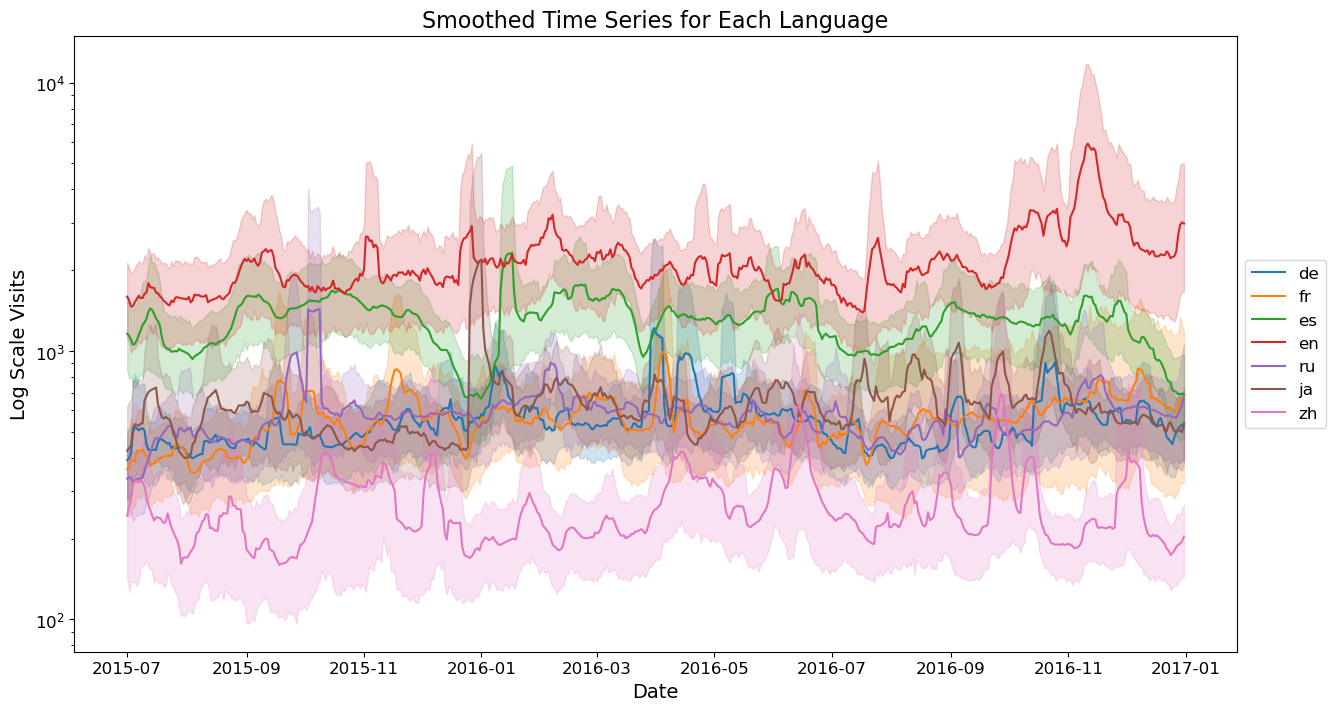

In [33]:
# plot time series for each language over time, make y axis log scale

fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(
    x='date', y='rolling_mean_visits', hue='language', data=df[df.language != 'missing'], ax=ax
)

# Set aesthetics
ax.set_title('Smoothed Time Series for Each Language', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Log Scale Visits', fontsize=14)
ax.set_yscale('log')
ax.tick_params(labelsize=12)

# Set legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/tmp/ipykernel_456287/2322588573.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels(axes[-1].get_xticklabels(), rotation=45, ha='right')


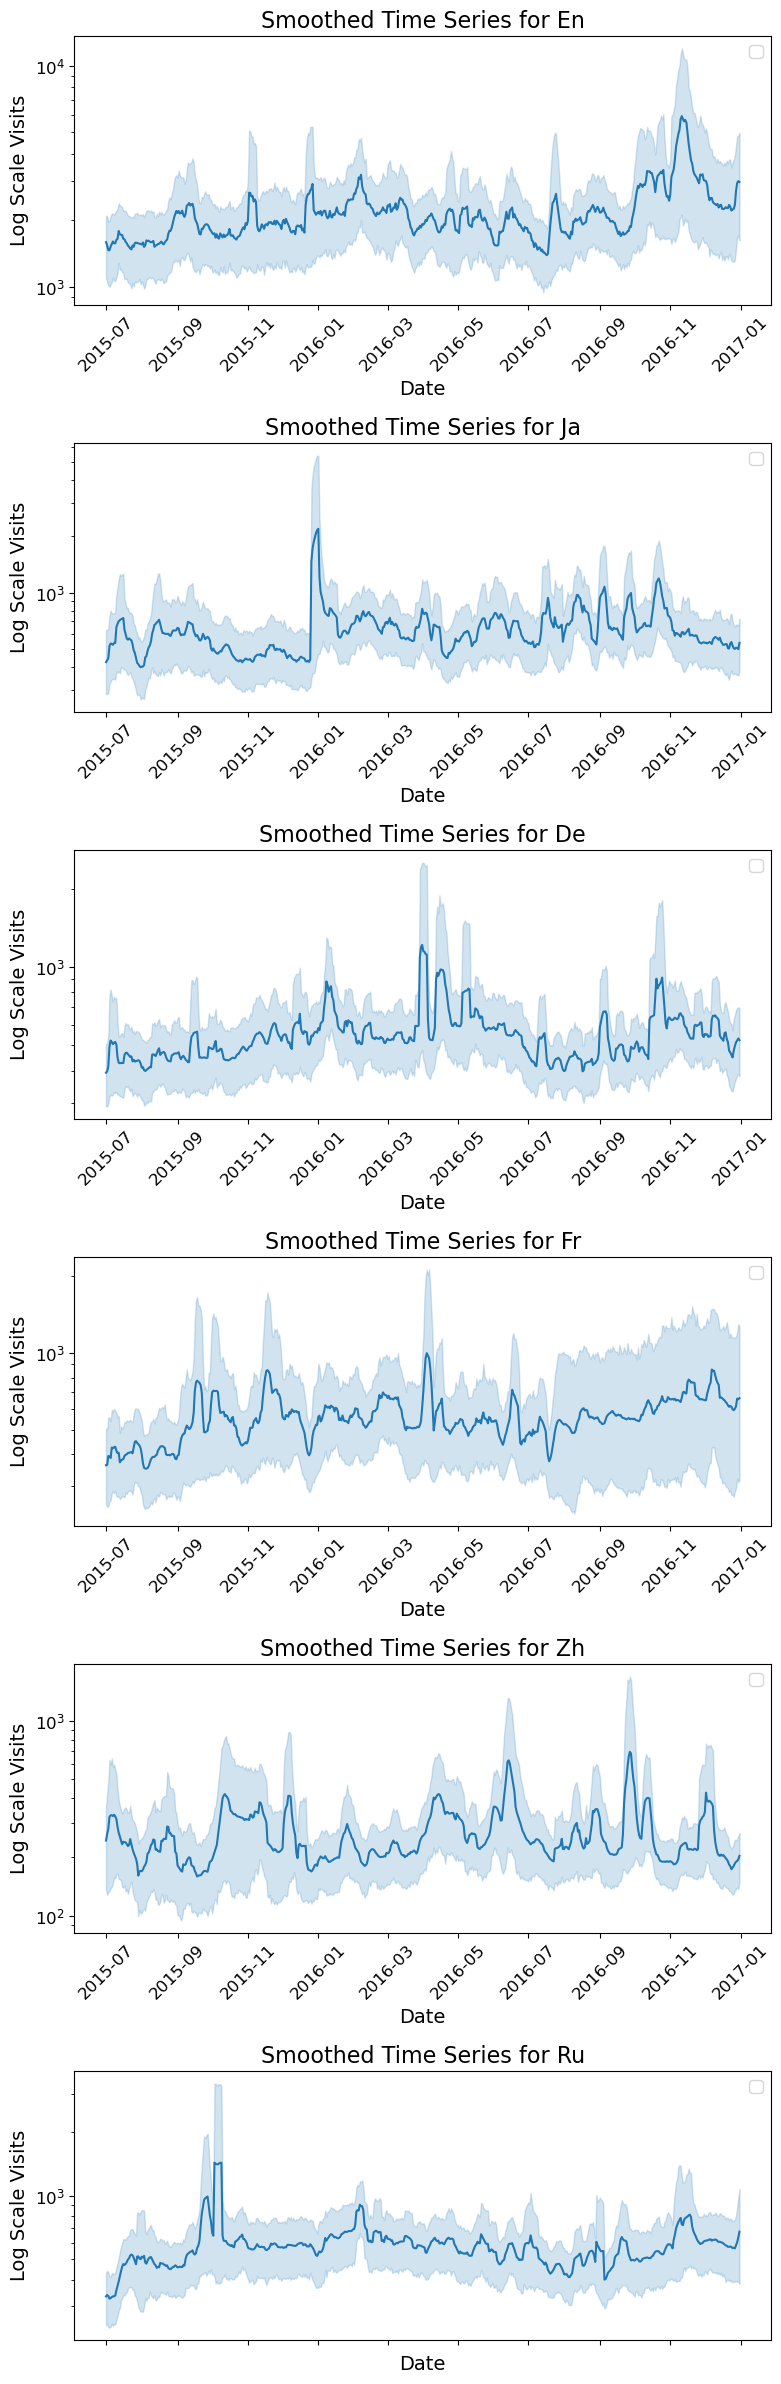

In [89]:
# plot time series for each language over time, make y axis log scale in separate plots
# Set figure size and font size
plt.rcParams['figure.figsize'] = [8, 24]
plt.rcParams['font.size'] = 12

# Create a list of languages to loop over
languages = ['en', 'ja', 'de', 'fr', 'zh', 'ru']

# Create a one-column grid of subplots
fig, axes = plt.subplots(len(languages), 1, sharex=False)

# Loop over the languages and create a line plot for each one
for i, language in enumerate(languages):
    ax = axes[i]
    sns.lineplot(x='date', y='rolling_mean_visits', data=df[df.language == language], ax=ax)
    ax.set_title(f'Smoothed Time Series for {language.capitalize()}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Log Scale Visits', fontsize=14)
    ax.set_yscale('log')
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

Let's explore teh distribution of web traffic by language, access type, and user agent. We are going to use seaborn to create histograms, boxplots, and violinplots to see how the distribution of visits varies across these different categories.

No handles with labels found to put in legend.


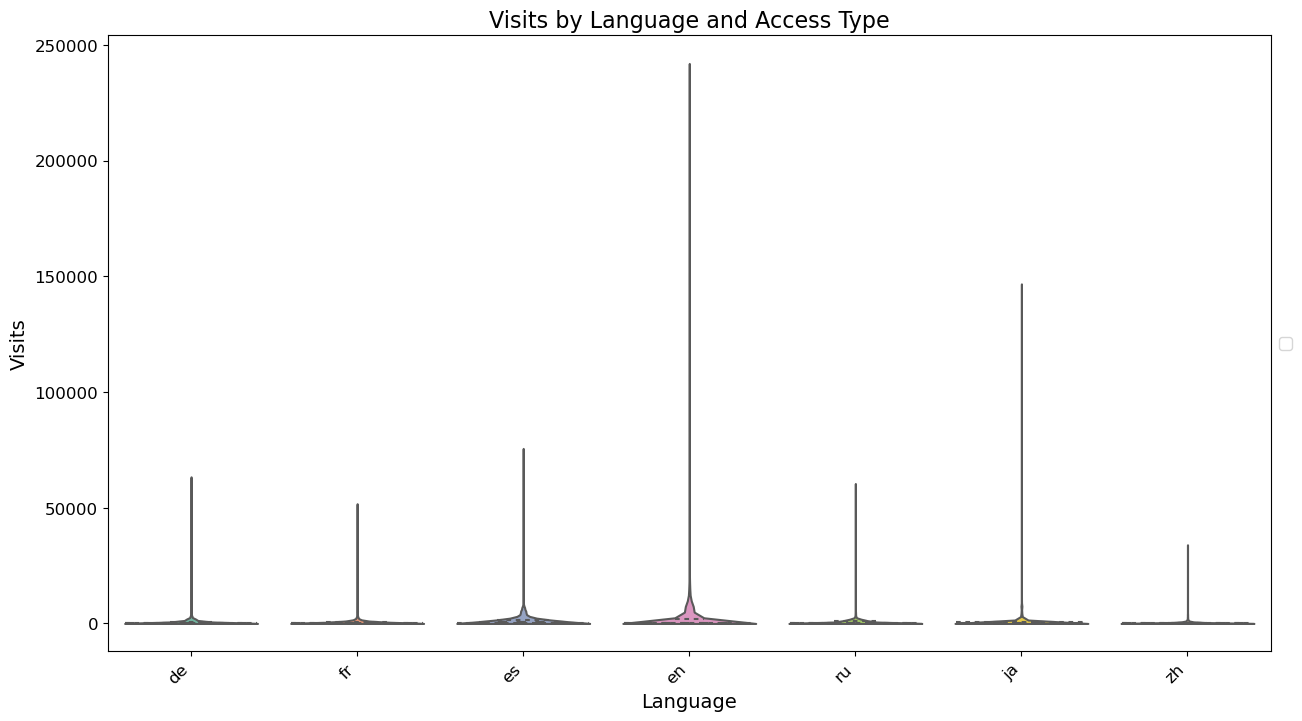

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))

# Use "Set2" color palette
colors = sns.color_palette('Set2')

# Increase the size of the violin plots
sns.violinplot(
    x='language',
    y='rolling_mean_visits',
    data=df[df.language != 'missing'],
    ax=ax,
    palette=colors,
    scale='width',
    inner='quartile',
    cut=0,
)
# sns.violinplot(x='language', y='visits', data=df[df.language !='missing'], ax=ax, scale='width')

# Set aesthetics
ax.set_title('Visits by Language and Access Type', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Visits', fontsize=14)
ax.tick_params(labelsize=12)

# Remove grid lines
ax.grid(False)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


# Set legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()

### How web traffic varies by day of the week, month, and year

We are going to create plots or bar charts to see if there are any regular patterns or seasonality in the data.

In [69]:
# plot how the web traffic varies by day of the week, month or year

# create a new column for day of the week
df['day_of_week'] = df['date'].dt.dayofweek

# create a new column for month
df['month'] = df['date'].dt.month

# create a new column for day of the year
df['day_of_year'] = df['date'].dt.dayofyear

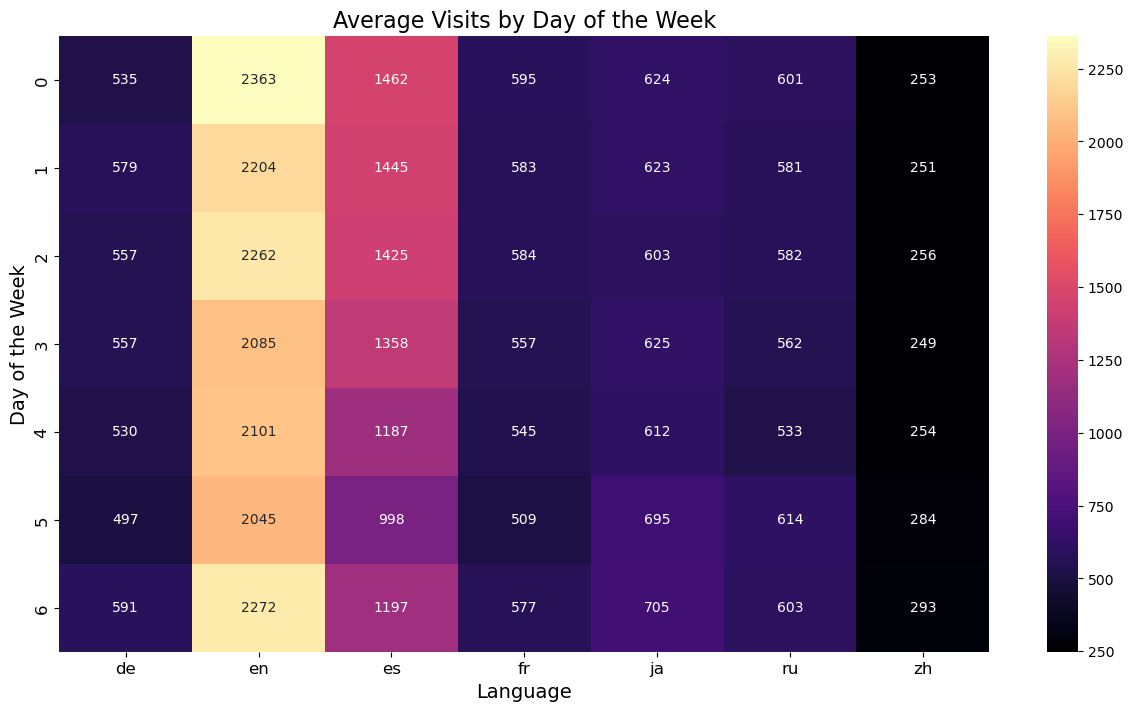

In [70]:
# heatmap of visits by day of the week and language

# create a pivot table
day_of_week = df[df.language != 'missing'].pivot_table(
    index='day_of_week', columns='language', values='visits', aggfunc='mean'
)

# create a heatmap
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(day_of_week, annot=True, fmt='.0f', cmap='magma', ax=ax)

# Set aesthetics
ax.set_title('Average Visits by Day of the Week', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Day of the Week', fontsize=14)
ax.tick_params(labelsize=12)

plt.show()

The plot above shows the average number of visits per day of the week. We can see that the number of visits is higher on Sunday and Monday for english pages. French and Chinese pages seem to have a steady or flat trend throughout the week. 

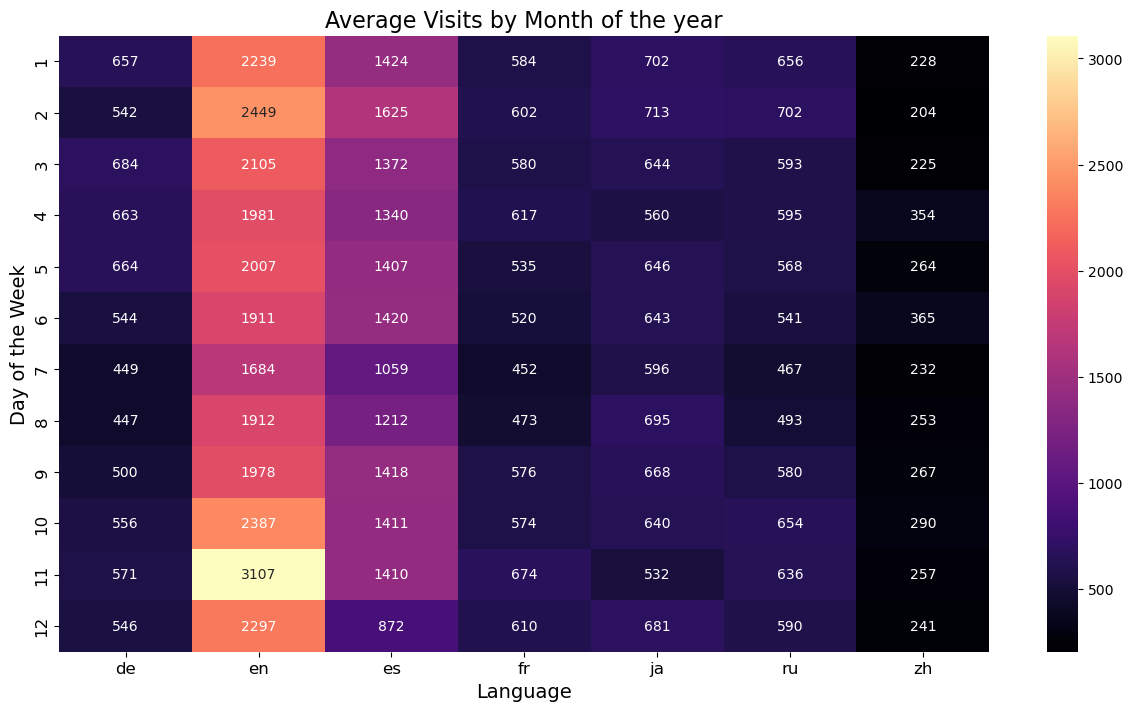

In [71]:
# heatmap of visits by day of the week and language

# create a pivot table
day_of_week = df[df.language != 'missing'].pivot_table(
    index='month', columns='language', values='visits', aggfunc='mean'
)

# create a heatmap
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(day_of_week, annot=True, fmt='.0f', cmap='magma', ax=ax)

# Set aesthetics
ax.set_title('Average Visits by Month of the year', fontsize=16)
ax.set_xlabel('Language', fontsize=14)
ax.set_ylabel('Day of the Week', fontsize=14)
ax.tick_params(labelsize=12)

plt.show()

### How web traffic varies by access type

In the plot below, we look at the distribution of visits by access type.

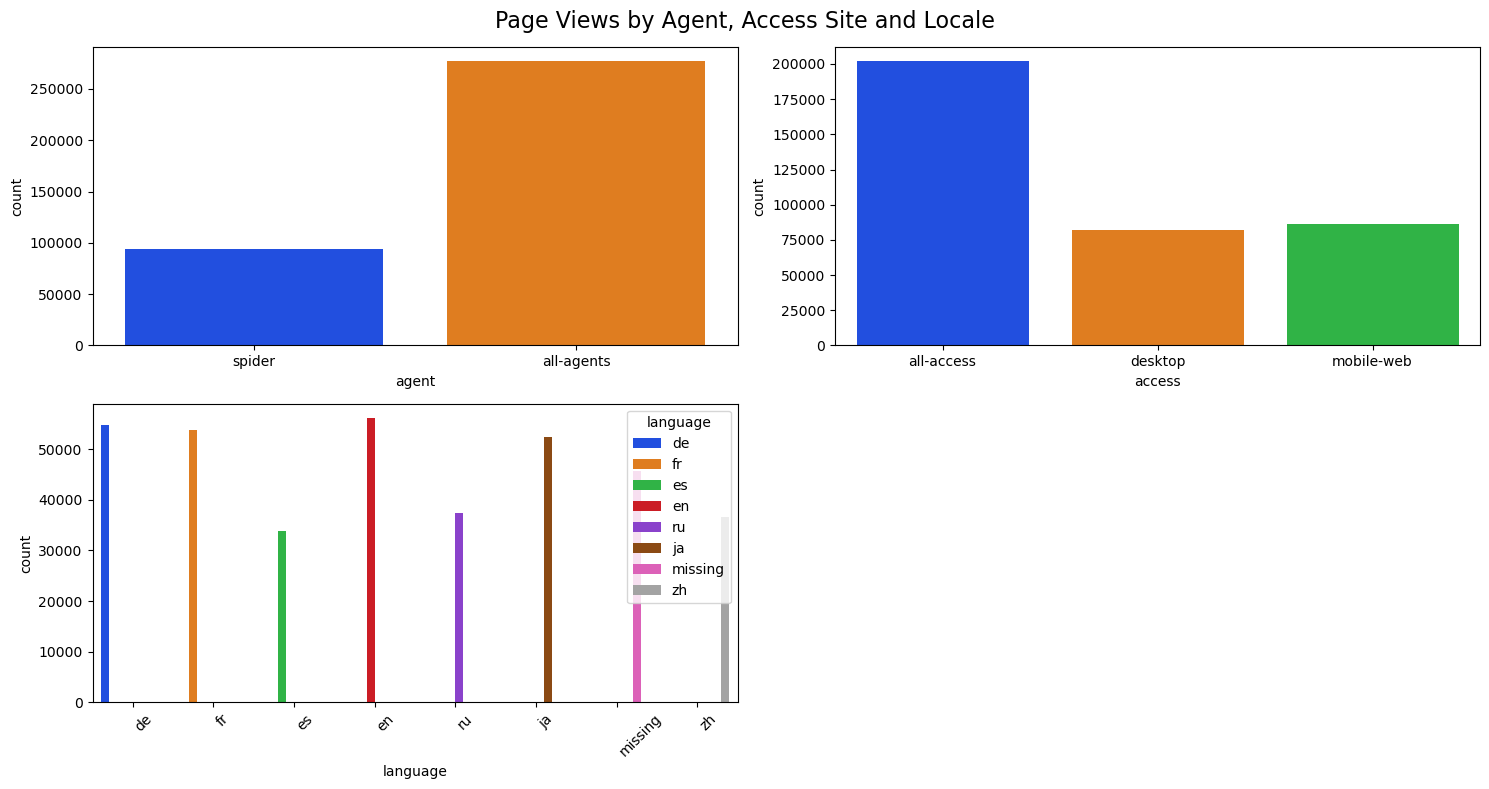

In [37]:
# layout the plots
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

# create plots
p1 = sns.countplot(data=df, x='agent', color='red', ax=ax[0, 0], palette='bright')
p2 = sns.countplot(data=df, x='access', color='red', ax=ax[0, 1], palette='bright')
p3 = sns.countplot(data=df, x='language', hue='language', ax=ax[1, 0], palette='bright')

# make sure p3 x-axis labels align with the bars
p3.set_xticklabels(p3.get_xticklabels(), rotation=45, horizontalalignment='left')

ax[1, 1].axis('off')

# set main title
fig.suptitle('Page Views by Agent, Access Site and Locale', fontsize=16)

fig.tight_layout()

As we can see from the plots above, the mobile-web access type is slightly more popular than the desktop access type.

### The most popular articles

Let's look at the most popular articles in the dataset. We will use the groupby function to group the data by page and sum the visits. We will then sort the data by visits in descending order.

In [72]:
# find the most visited articles for each language

janitor.groupby_topk(
    df[df.language != 'missing']
    .groupby(['language', 'article'])['visits']
    .sum()
    .sort_values(ascending=False)
    .reset_index(),
    'language',
    'visits',
    1,
    {'ascending': False},
)

,,language,article,visits
language,,,,
de,32,de,London,1659273.0
en,0,en,Elizabeth_II,13333936.0
es,14,es,Síndrome_de_Asperger,3581011.0
fr,2,fr,France,5721186.0
ja,9,ja,日本,4087437.0
ru,30,ru,Владимир_Святославич,1763293.0
zh,90,zh,少年四大名捕_(2015年电视剧),773781.0


## Modeling  



In [73]:
df.head()

,page,date,visits,id,language,access,agent,article,rolling_mean_visits,day_of_week,month,day_of_year
0,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-01,3.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,3.000000,2,7,182
1,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-02,2.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,2.500000,3,7,183
2,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-03,2.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,2.333333,4,7,184
3,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-04,10.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,4.250000,5,7,185
4,Charles_Brauer_de.wikipedia.org_all-access_spider,2015-07-05,1.0,Charles_Brauer_de.wikipedia.org_all-access_spi...,de,all-access,spider,Charles_Brauer,3.600000,6,7,186


In [84]:
data = df.dropna(subset=['article'])[
    [
        'id',
        'rolling_mean_visits',
        'date',
        'page',
        'day_of_week',
        'month',
        'day_of_year',
        'language',
        'access',
        'agent',
    ]
].copy()

# split data into train and test sets
cut_off_date = '2016-09-01'
val_cut_off_date = '2016-10-01'
train = data[data.date < cut_off_date].drop('date', axis=1)
val = data[(data.date >= cut_off_date) & (data.date < val_cut_off_date)].drop('date', axis=1)
test = data[data.date >= val_cut_off_date].drop('date', axis=1)


# print the shape of the train and test sets
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Val shape: {val.shape}')

Train shape: (281359, 9)
Test shape: (64054, 9)
Val shape: (20662, 9)


In [85]:
train.head()

,id,rolling_mean_visits,page,day_of_week,month,day_of_year,language,access,agent
0,Charles_Brauer_de.wikipedia.org_all-access_spi...,3.000000,Charles_Brauer_de.wikipedia.org_all-access_spider,2,7,182,de,all-access,spider
1,Charles_Brauer_de.wikipedia.org_all-access_spi...,2.500000,Charles_Brauer_de.wikipedia.org_all-access_spider,3,7,183,de,all-access,spider
2,Charles_Brauer_de.wikipedia.org_all-access_spi...,2.333333,Charles_Brauer_de.wikipedia.org_all-access_spider,4,7,184,de,all-access,spider
3,Charles_Brauer_de.wikipedia.org_all-access_spi...,4.250000,Charles_Brauer_de.wikipedia.org_all-access_spider,5,7,185,de,all-access,spider
4,Charles_Brauer_de.wikipedia.org_all-access_spi...,3.600000,Charles_Brauer_de.wikipedia.org_all-access_spider,6,7,186,de,all-access,spider


In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302021 entries, 0 to 370599
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   302021 non-null  object 
 1   rolling_mean_visits  302021 non-null  float64
 2   page                 302021 non-null  object 
 3   day_of_week          302021 non-null  int64  
 4   month                302021 non-null  int64  
 5   day_of_year          302021 non-null  int64  
 6   language             302021 non-null  object 
 7   access               302021 non-null  object 
 8   agent                302021 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 23.0+ MB


In [52]:
import tensorflow as tf

?tf.keras.preprocessing.timeseries_dataset_from_array

Signature:
tf.keras.preprocessing.timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
)
Docstring:
Creates a dataset of sliding windows over a timeseries provided as array.

This function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
length of the sequences/windows, spacing between two sequence/windows, etc.,
to produce batches of timeseries inputs and targets.

Args:
  data: Numpy array or eager tensor
    containing consecutive data points (timesteps).
    Axis 0 is expected to be the time dimension.
  targets: Targets corresponding to timesteps in `data`.
    `targets[i]` should be the target
    corresponding to the window that starts at index `i`
    (see example 2 below).
    Pass None if you don't have target data (in this case the dataset will
    only yield 